# SPAM SMS - CLASSIFICATION AND TOPIC MODELLING

# 1. SMS Classification

_Reference_:

https://machinelearningmastery.com/deep-learning-for-nlp/

https://machinelearningmastery.com/clean-text-machine-learning-python/?fbclid=IwAR1Zu4lFlGkdW7bdEZz01sLEo2VNj-7yhKN92ZLOqlTfeBQWC8XSiNkCpks

https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/?fbclid=IwAR2KthsKRrP9eZ_ezZQEse_5bwWJ8pH1r9DvXtv5UtCTRpvanuE6BbKtehU

_About Dataset_:

"The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam".

The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

https://www.kaggle.com/uciml/sms-spam-collection-dataset

### Library and Data

In [1]:
import tensorflow as tf

In [118]:
import numpy as np    
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,f1_score   

import string
import re
from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils  import to_categorical
from keras.layers import Input
from keras.layers import Dropout
from keras.layers.merge import concatenate
from keras.models import Model
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [4]:
mydf = pd.read_csv('spam.csv',
                    encoding = "latin-1")
mydf = mydf.iloc[:,0:2] 

### Cleaning / Processing Text

In [5]:
### turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

In [6]:
#### fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [7]:
import nltk
nltk.download('stopwords')
# Using the stopwords.
from nltk.corpus import stopwords
# Initialize the stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
mydf['clean_text']=mydf['Text'].apply(lambda row : clean_doc(row))

mydf['Text_len'] = mydf['Text'].apply(lambda x: len(x) - x.count(" "))

mydf.drop("Text", axis=1, inplace=True)

In [9]:
X_train,X_test,y_train,y_test = train_test_split(mydf,mydf['Label'],test_size=.15)  

In [10]:
print(y_train.value_counts())
print(y_test.value_counts())

ham     4103
spam     633
Name: Label, dtype: int64
ham     722
spam    114
Name: Label, dtype: int64


In [11]:
max_length_train = mydf['clean_text'].apply(lambda x: len(x)).max()
    
train_docs = X_train['clean_text']
    
tokenizer_train = create_tokenizer(train_docs)

encoded_train = tokenizer_train.texts_to_sequences(train_docs)

padded_train = pad_sequences(encoded_train, maxlen=max_length_train, padding='post')

padded_train_df = pd.DataFrame(padded_train)

In [12]:
max_length_test = mydf['clean_text'].apply(lambda x: len(x)).max()
    
test_docs = X_test['clean_text']
    
encoded_test = tokenizer_train.texts_to_sequences(test_docs)

padded_test = pad_sequences(encoded_test, maxlen=max_length_test, padding='post')

padded_test_df = pd.DataFrame(padded_test)    

###  Model 1 - CNN With Embedding Layer 

In [13]:
# define the model
def define_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize defined model
    model.summary()
    return model

In [14]:
y_train[y_train == 'ham'] = 0
y_train[y_train == 'spam'] = 1
to_categorical(y_train)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [15]:
y_test[y_test == 'ham'] = 0
y_test[y_test == 'spam'] = 1
to_categorical(y_test)

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [16]:
max_length = mydf['clean_text'].apply(lambda x: len(x)).max()
max_length

81

In [17]:
# define vocabulary size
vocab_size = len(tokenizer_train.word_index) + 1
print('Vocabulary size: %d' % vocab_size)

Vocabulary size: 7507


In [18]:
modelCNN = define_model(vocab_size, max_length)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 100)           750700    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 74, 32)            25632     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 37, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1184)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                11850     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 788,193
Trainable params: 788,193
Non-trainable params: 0
________________________________________________

In [19]:
modelCNN.fit(padded_train_df, y_train, epochs=10, verbose=2)

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
 - 3s - loss: 0.2844 - accuracy: 0.8752
Epoch 2/10
 - 3s - loss: 0.1174 - accuracy: 0.9842
Epoch 3/10
 - 3s - loss: 0.0940 - accuracy: 0.9937
Epoch 4/10
 - 3s - loss: 0.0820 - accuracy: 0.9975
Epoch 5/10
 - 3s - loss: 0.0740 - accuracy: 0.9983
Epoch 6/10
 - 3s - loss: 0.0671 - accuracy: 0.9985
Epoch 7/10
 - 3s - loss: 0.0622 - accuracy: 0.9985
Epoch 8/10
 - 3s - loss: 0.0559 - accuracy: 0.9989
Epoch 9/10
 - 3s - loss: 0.0524 - accuracy: 0.9987
Epoch 10/10
 - 3s - loss: 0.0470 - accuracy: 0.9994


In [20]:
# evaluate model on train dataset
_, acc_train = modelCNN.evaluate(padded_train_df, y_train, verbose=0)
print('Train Accuracy: %f' % (acc_train*100))

Train Accuracy: 99.957770


In [21]:
# evaluate model on test dataset
_, acc_test = modelCNN.evaluate(padded_test_df, y_test, verbose=0)
print('Test Accuracy: %f' % (acc_test*100))

Test Accuracy: 98.923445


In [22]:
predict_test = np.round(modelCNN.predict(padded_test_df)).astype(int)
predict_test = predict_test.flatten()
predict_test = pd.Series(predict_test)

In [23]:
confusion_matrix(y_test.astype(int), predict_test)
tn, fp, fn, tp =confusion_matrix(y_test.astype(int), predict_test).ravel()

In [24]:
f1 = f1_score(y_test.astype(int), predict_test)
print('Test F1 Score: %f' % (f1*100))

Test F1 Score: 95.890411


Model 1 is CNN With Embedding Layer.

Model 1 has 100% Accuracy on Trainset and 98.9% Accuracy on Testset. 

The Dataset is Imbalanced so F1-Score of Model 1 on Testset is 96.0%.

### Tuning Model 1

Tuning Parameters Batch_Size and Epochs for Model 1 for Better Deep Learning model performance

In [25]:
# define the model
def define_model1():
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize defined model
    model.summary()
    return model

In [26]:
# Create a KerasClassifier
model1 = KerasClassifier(build_fn = define_model1)

In [30]:
# Define the parameters to try out
params1 = {   
            'batch_size': [6,10,14,18], 
            'epochs': [2,4,6,8,10]
          }

In [31]:
random_search1 = RandomizedSearchCV(model1, param_distributions = params1, cv = KFold(5))

In [32]:
random_search1.fit(padded_train_df, y_train, verbose = 1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 81, 100)           750700    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 74, 32)            25632     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 37, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1184)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                11850     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 788,193
Trainable params: 788,193
Non-trainable params: 0
________________________________________________

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/8
3788/3788 [==============================] - 5s 1ms/step - loss: 0.1986 - accuracy: 0.9205
Epoch 2/8
3788/3788 [==============================] - 5s 1ms/step - loss: 0.0289 - accuracy: 0.9926
Epoch 3/8
3788/3788 [==============================] - 5s 1ms/step - loss: 0.0059 - accuracy: 0.9989
Epoch 4/8
3788/3788 [==============================] - 5s 1ms/step - loss: 0.0033 - accuracy: 0.9992
Epoch 5/8
3788/3788 [==============================] - 5s 1ms/step - loss: 0.0020 - accuracy: 0.9995
Epoch 6/8
3788/3788 [==============================] - 5s 1ms/step - loss: 0.0018 - accuracy: 0.9997
Epoch 7/8
3788/3788 [==============================] - 5s 1ms/step - loss: 0.0016 - accuracy: 0.9995
Epoch 8/8
948/948 [==============================] - 0s 189us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 81, 100)           750700    
______

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.2247 - accuracy: 0.9232
Epoch 2/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0743 - accuracy: 0.9913
Epoch 3/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0146 - accuracy: 0.9968
Epoch 4/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0059 - accuracy: 0.9987
Epoch 5/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0033 - accuracy: 0.9995
Epoch 6/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0036 - accuracy: 0.9992
Epoch 7/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0028 - accuracy: 0.9995
Epoch 8/8
947/947 [==============================] - 0s 167us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 81, 100)           750700    
______

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.2218 - accuracy: 0.9219
Epoch 2/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.1051 - accuracy: 0.9900
Epoch 3/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0569 - accuracy: 0.9952
Epoch 4/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0108 - accuracy: 0.9971
Epoch 5/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0032 - accuracy: 0.9995
Epoch 6/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0020 - accuracy: 0.9997
Epoch 7/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0017 - accuracy: 0.9997
Epoch 8/8
947/947 [==============================] - 0s 211us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 81, 100)           750700    
______

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.2241 - accuracy: 0.9155
Epoch 2/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0998 - accuracy: 0.9934
Epoch 3/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0777 - accuracy: 0.9979
Epoch 4/8
3789/3789 [==============================] - ETA: 0s - loss: 0.0670 - accuracy: 0.99 - 5s 1ms/step - loss: 0.0667 - accuracy: 0.9987
Epoch 5/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0436 - accuracy: 0.9997
Epoch 6/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0017 - accuracy: 0.9997 ETA: 3s - loss: 1.728
Epoch 7/8
3789/3789 [==============================] - 5s 1ms/step - loss: 9.0033e-04 - accuracy: 0.9997
Epoch 8/8
947/947 [==============================] - 0s 167us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embe

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.1719 - accuracy: 0.9393
Epoch 2/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0243 - accuracy: 0.9923
Epoch 3/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0081 - accuracy: 0.9984
Epoch 4/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0033 - accuracy: 0.9995
Epoch 5/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0028 - accuracy: 0.9995
Epoch 6/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0022 - accuracy: 0.9997
Epoch 7/8
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0025 - accuracy: 0.9997
Epoch 8/8
947/947 [==============================] - 0s 169us/step
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 81, 100)           750700    
______

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
3788/3788 [==============================] - 4s 1ms/step - loss: 0.2560 - accuracy: 0.8989
Epoch 2/10
3788/3788 [==============================] - 4s 1ms/step - loss: 0.1112 - accuracy: 0.9865
Epoch 3/10
3788/3788 [==============================] - 4s 1ms/step - loss: 0.0857 - accuracy: 0.9950
Epoch 4/10
3788/3788 [==============================] - 4s 1ms/step - loss: 0.0743 - accuracy: 0.9971
Epoch 5/10
3788/3788 [==============================] - 4s 1ms/step - loss: 0.0653 - accuracy: 0.9974
Epoch 6/10
3788/3788 [==============================] - 4s 1ms/step - loss: 0.0583 - accuracy: 0.9987
Epoch 7/10
3788/3788 [==============================] - 4s 1ms/step - loss: 0.0512 - accuracy: 0.9989
Epoch 8/10
3788/3788 [==============================] - 4s 1ms/step - loss: 0.0462 - accuracy: 0.9989
Epoch 9/10
3788/3788 [==============================] - 4s 1ms/step - loss: 0.0408 - accuracy: 0.9992
Epoch 10/10
948/948 [==============================] - 0s 108us/step
Model: "seque

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.2329 - accuracy: 0.9158
Epoch 2/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.1074 - accuracy: 0.9889
Epoch 3/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0860 - accuracy: 0.9955
Epoch 4/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0747 - accuracy: 0.9976
Epoch 5/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0655 - accuracy: 0.9982
Epoch 6/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0583 - accuracy: 0.9984
Epoch 7/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0517 - accuracy: 0.9984
Epoch 8/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0466 - accuracy: 0.9984
Epoch 9/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0115 - accuracy: 0.9976
Epoch 10/10
947/947 [==============================] - 0s 126us/step
Model: "seque

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.2342 - accuracy: 0.9148
Epoch 2/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.1044 - accuracy: 0.9905
Epoch 3/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0839 - accuracy: 0.9952
Epoch 4/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0720 - accuracy: 0.9971
Epoch 5/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0645 - accuracy: 0.9979
Epoch 6/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0554 - accuracy: 0.9987
Epoch 7/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0488 - accuracy: 0.9992
Epoch 8/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0438 - accuracy: 0.9992
Epoch 9/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0388 - accuracy: 0.9995
Epoch 10/10
947/947 [==============================] - 0s 110us/step
Model: "seque

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.2343 - accuracy: 0.9150
Epoch 2/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.1018 - accuracy: 0.9892
Epoch 3/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0285 - accuracy: 0.9955
Epoch 4/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0041 - accuracy: 0.9992
Epoch 5/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0023 - accuracy: 0.9995
Epoch 6/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0018 - accuracy: 0.9997
Epoch 7/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0013 - accuracy: 0.9997
Epoch 8/10
3789/3789 [==============================] - 4s 1ms/step - loss: 9.8121e-04 - accuracy: 0.9997
Epoch 9/10
3789/3789 [==============================] - 4s 1ms/step - loss: 3.2913e-04 - accuracy: 0.9997
Epoch 10/10
947/947 [==============================] - 0s 118us/step
Model

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.2347 - accuracy: 0.9129TA: 0s - loss: 0.2
Epoch 2/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.1075 - accuracy: 0.9910: 0s - loss: 0.104
Epoch 3/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0858 - accuracy: 0.9950
Epoch 4/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0718 - accuracy: 0.9974
Epoch 5/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0635 - accuracy: 0.9979: 1s - ETA: 0s - loss: 0.0648 - accuracy
Epoch 6/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0569 - accuracy: 0.9984
Epoch 7/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0510 - accuracy: 0.9984
Epoch 8/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0453 - accuracy: 0.9989
Epoch 9/10
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0404 - accuracy: 0.9989
Epoch 

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
3788/3788 [==============================] - 7s 2ms/step - loss: 0.2055 - accuracy: 0.9340
Epoch 2/10
3788/3788 [==============================] - 7s 2ms/step - loss: 0.0947 - accuracy: 0.9916
Epoch 3/10
3788/3788 [==============================] - 7s 2ms/step - loss: 0.0701 - accuracy: 0.9968
Epoch 4/10
3788/3788 [==============================] - 7s 2ms/step - loss: 0.0581 - accuracy: 0.9984
Epoch 5/10
3788/3788 [==============================] - 7s 2ms/step - loss: 0.0478 - accuracy: 0.9987
Epoch 6/10
3788/3788 [==============================] - 7s 2ms/step - loss: 0.0397 - accuracy: 0.9989
Epoch 7/10
3788/3788 [==============================] - 7s 2ms/step - loss: 0.0066 - accuracy: 0.9989
Epoch 8/10
3788/3788 [==============================] - 7s 2ms/step - loss: 0.0032 - accuracy: 0.9989
Epoch 9/10
3788/3788 [==============================] - 7s 2ms/step - loss: 9.7931e-04 - accuracy: 0.9997 - loss: 0.001
Epoch 10/10
948/948 [==============================] - 0s 190us/

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
3789/3789 [==============================] - 7s 2ms/step - loss: 0.2118 - accuracy: 0.9293
Epoch 2/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0965 - accuracy: 0.9910
Epoch 3/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0734 - accuracy: 0.9963
Epoch 4/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0479 - accuracy: 0.9974
Epoch 5/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0105 - accuracy: 0.9974
Epoch 6/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0018 - accuracy: 0.9995
Epoch 7/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0021 - accuracy: 0.9995
Epoch 8/10
3789/3789 [==============================] - 6s 2ms/step - loss: 9.1156e-04 - accuracy: 0.9995
Epoch 9/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0013 - accuracy: 0.9997
Epoch 10/10
947/947 [==============================] - 0s 189us/step
Model: "s

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
3789/3789 [==============================] - 7s 2ms/step - loss: 0.1847 - accuracy: 0.9369
Epoch 2/10
3789/3789 [==============================] - 7s 2ms/step - loss: 0.0258 - accuracy: 0.9931
Epoch 3/10
3789/3789 [==============================] - 7s 2ms/step - loss: 0.0081 - accuracy: 0.9982
Epoch 4/10
3789/3789 [==============================] - 7s 2ms/step - loss: 0.0041 - accuracy: 0.9995
Epoch 5/10
3789/3789 [==============================] - 7s 2ms/step - loss: 0.0032 - accuracy: 0.9995
Epoch 6/10
3789/3789 [==============================] - 7s 2ms/step - loss: 0.0023 - accuracy: 0.9992
Epoch 7/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0015 - accuracy: 0.9995
Epoch 8/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0014 - accuracy: 0.9997
Epoch 9/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0013 - accuracy: 0.9997
Epoch 10/10
947/947 [==============================] - 0s 182us/step
Model: "seque

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
3789/3789 [==============================] - 7s 2ms/step - loss: 0.1869 - accuracy: 0.9375: 0s - loss: 0.1890 - accuracy: 
Epoch 2/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0246 - accuracy: 0.9934
Epoch 3/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0047 - accuracy: 0.9987
Epoch 4/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0018 - accuracy: 0.9997
Epoch 5/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0017 - accuracy: 0.9995
Epoch 6/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0012 - accuracy: 0.9997
Epoch 7/10
3789/3789 [==============================] - 6s 2ms/step - loss: 7.2206e-05 - accuracy: 1.0000
Epoch 8/10
3789/3789 [==============================] - 6s 2ms/step - loss: 6.0084e-05 - accuracy: 1.0000
Epoch 9/10
3789/3789 [==============================] - 6s 2ms/step - loss: 3.5437e-05 - accuracy: 1.0000
Epoch 10/10
947/947 [=================

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.1889 - accuracy: 0.9274
Epoch 2/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0292 - accuracy: 0.9918
Epoch 3/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0058 - accuracy: 0.9987
Epoch 4/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0029 - accuracy: 0.9997
Epoch 5/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0024 - accuracy: 0.9997
Epoch 6/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0023 - accuracy: 0.9997
Epoch 7/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0019 - accuracy: 0.9997
Epoch 8/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0023 - accuracy: 0.9997
Epoch 9/10
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0016 - accuracy: 0.9997
Epoch 10/10
947/947 [==============================] - 0s 217us/step
Model: "seque

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/4
3788/3788 [==============================] - 7s 2ms/step - loss: 0.1800 - accuracy: 0.9345
Epoch 2/4
3788/3788 [==============================] - 6s 2ms/step - loss: 0.0216 - accuracy: 0.9939
Epoch 3/4
3788/3788 [==============================] - 6s 2ms/step - loss: 0.0055 - accuracy: 0.9989
Epoch 4/4
948/948 [==============================] - 0s 188us/step
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 37, 32)            0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 1184)              0         
_____________

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/4
3789/3789 [==============================] - 7s 2ms/step - loss: 0.2134 - accuracy: 0.9256
Epoch 2/4
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0984 - accuracy: 0.9905
Epoch 3/4
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0784 - accuracy: 0.9952
Epoch 4/4
947/947 [==============================] - 0s 185us/step
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 37, 32)            0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 1184)              0         
_____________

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/4
3789/3789 [==============================] - 6s 2ms/step - loss: 0.1950 - accuracy: 0.9396
Epoch 2/4
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0961 - accuracy: 0.9908
Epoch 3/4
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0713 - accuracy: 0.9971
Epoch 4/4
947/947 [==============================] - 0s 220us/step
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 37, 32)            0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 1184)              0         
_____________

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/4
3789/3789 [==============================] - 6s 2ms/step - loss: 0.2247 - accuracy: 0.9169
Epoch 2/4
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0984 - accuracy: 0.9905: 0s - loss: 0.1015 - accuracy:  - ETA: 0s - loss: 0.1009 
Epoch 3/4
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0754 - accuracy: 0.9950
Epoch 4/4
947/947 [==============================] - 0s 186us/step
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 37, 32)            0         
_________________________________________________________________
flatten_21 (Flatten) 

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/4
3789/3789 [==============================] - 7s 2ms/step - loss: 0.1678 - accuracy: 0.9364
Epoch 2/4
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0242 - accuracy: 0.9937
Epoch 3/4
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0057 - accuracy: 0.9989
Epoch 4/4
947/947 [==============================] - 0s 188us/step
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 37, 32)            0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 1184)              0         
_____________

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/2
3788/3788 [==============================] - 6s 2ms/step - loss: 0.1684 - accuracy: 0.9446
Epoch 2/2
948/948 [==============================] - 0s 186us/step
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 37, 32)            0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 1184)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 10)                11850     
_________________________________________________________________
dense_46 (Dense) 

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/2
3789/3789 [==============================] - 6s 2ms/step - loss: 0.2245 - accuracy: 0.9240
Epoch 2/2
947/947 [==============================] - 0s 217us/step
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 37, 32)            0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 1184)              0         
_________________________________________________________________
dense_47 (Dense)             (None, 10)                11850     
_________________________________________________________________
dense_48 (Dense) 

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/2
3789/3789 [==============================] - 7s 2ms/step - loss: 0.1968 - accuracy: 0.9390
Epoch 2/2
947/947 [==============================] - 0s 201us/step
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 37, 32)            0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 1184)              0         
_________________________________________________________________
dense_49 (Dense)             (None, 10)                11850     
_________________________________________________________________
dense_50 (Dense) 

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/2
3789/3789 [==============================] - 7s 2ms/step - loss: 0.2038 - accuracy: 0.9324
Epoch 2/2
947/947 [==============================] - 0s 201us/step
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 37, 32)            0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 1184)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 10)                11850     
_________________________________________________________________
dense_52 (Dense) 

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/2
3789/3789 [==============================] - 7s 2ms/step - loss: 0.2043 - accuracy: 0.9314
Epoch 2/2
947/947 [==============================] - 0s 195us/step
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 37, 32)            0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 1184)              0         
_________________________________________________________________
dense_53 (Dense)             (None, 10)                11850     
_________________________________________________________________
dense_54 (Dense) 

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/4
3788/3788 [==============================] - 10s 3ms/step - loss: 0.1949 - accuracy: 0.9414
Epoch 2/4
3788/3788 [==============================] - 10s 3ms/step - loss: 0.0883 - accuracy: 0.9902
Epoch 3/4
3788/3788 [==============================] - 10s 3ms/step - loss: 0.0632 - accuracy: 0.9963
Epoch 4/4
948/948 [==============================] - 0s 233us/step
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 37, 32)            0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 1184)              0         
__________

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/4
3789/3789 [==============================] - 10s 3ms/step - loss: 0.1982 - accuracy: 0.9385
Epoch 2/4
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0885 - accuracy: 0.9910
Epoch 3/4
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0618 - accuracy: 0.9968
Epoch 4/4
947/947 [==============================] - 0s 239us/step
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 37, 32)            0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 1184)              0         
__________

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/4
3789/3789 [==============================] - 10s 3ms/step - loss: 0.1994 - accuracy: 0.9404
Epoch 2/4
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0577 - accuracy: 0.9923
Epoch 3/4
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0109 - accuracy: 0.9968
Epoch 4/4
947/947 [==============================] - 0s 220us/step
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 37, 32)            0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 1184)              0         
__________

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/4
3789/3789 [==============================] - 11s 3ms/step - loss: 0.1320 - accuracy: 0.9554
Epoch 2/4
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0167 - accuracy: 0.9963
Epoch 3/4
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0046 - accuracy: 0.9989
Epoch 4/4
947/947 [==============================] - 0s 226us/step
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 37, 32)            0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 1184)              0         
__________

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/4
3789/3789 [==============================] - 10s 3ms/step - loss: 0.1557 - accuracy: 0.9448
Epoch 2/4
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0222 - accuracy: 0.9926
Epoch 3/4
3789/3789 [==============================] - 11s 3ms/step - loss: 0.0085 - accuracy: 0.9976
Epoch 4/4
947/947 [==============================] - 0s 240us/step
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 37, 32)            0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 1184)              0         
__________

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/8
3788/3788 [==============================] - 7s 2ms/step - loss: 0.1726 - accuracy: 0.9388
Epoch 2/8
3788/3788 [==============================] - 7s 2ms/step - loss: 0.0270 - accuracy: 0.9918
Epoch 3/8
3788/3788 [==============================] - 7s 2ms/step - loss: 0.0061 - accuracy: 0.9987
Epoch 4/8
3788/3788 [==============================] - 6s 2ms/step - loss: 0.0039 - accuracy: 0.9995
Epoch 5/8
3788/3788 [==============================] - 7s 2ms/step - loss: 0.0024 - accuracy: 0.9995
Epoch 6/8
3788/3788 [==============================] - 7s 2ms/step - loss: 0.0016 - accuracy: 0.9995
Epoch 7/8
3788/3788 [==============================] - 7s 2ms/step - loss: 0.0014 - accuracy: 0.9997
Epoch 8/8
948/948 [==============================] - 0s 204us/step
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 81, 100)           750700    
_____

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/8
3789/3789 [==============================] - 7s 2ms/step - loss: 0.1808 - accuracy: 0.9319
Epoch 2/8
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0228 - accuracy: 0.9942
Epoch 3/8
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0073 - accuracy: 0.9989
Epoch 4/8
3789/3789 [==============================] - 7s 2ms/step - loss: 0.0042 - accuracy: 0.9992
Epoch 5/8
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0026 - accuracy: 0.9995
Epoch 6/8
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0019 - accuracy: 0.9995
Epoch 7/8
3789/3789 [==============================] - 7s 2ms/step - loss: 0.0015 - accuracy: 0.9995
Epoch 8/8
947/947 [==============================] - 0s 192us/step
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 81, 100)           750700    
_____

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/8
3789/3789 [==============================] - 7s 2ms/step - loss: 0.2332 - accuracy: 0.9155
Epoch 2/8
3789/3789 [==============================] - 6s 2ms/step - loss: 0.1011 - accuracy: 0.9892
Epoch 3/8
3789/3789 [==============================] - 7s 2ms/step - loss: 0.0170 - accuracy: 0.9955
Epoch 4/8
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0050 - accuracy: 0.9989
Epoch 5/8
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0034 - accuracy: 0.9995
Epoch 6/8
3789/3789 [==============================] - 7s 2ms/step - loss: 0.0019 - accuracy: 0.9995
Epoch 7/8
3789/3789 [==============================] - 7s 2ms/step - loss: 0.0018 - accuracy: 0.9997
Epoch 8/8
947/947 [==============================] - 0s 208us/step
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 81, 100)           750700    
_____

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/8
3789/3789 [==============================] - 6s 2ms/step - loss: 0.1985 - accuracy: 0.9327
Epoch 2/8
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0967 - accuracy: 0.9916
Epoch 3/8
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0707 - accuracy: 0.9971
Epoch 4/8
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0574 - accuracy: 0.9984
Epoch 5/8
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0517 - accuracy: 0.9968
Epoch 6/8
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0248 - accuracy: 0.9984
Epoch 7/8
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0016 - accuracy: 0.9995
Epoch 8/8
947/947 [==============================] - 0s 190us/step
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 81, 100)           750700    
_____

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/8
3789/3789 [==============================] - 6s 2ms/step - loss: 0.2104 - accuracy: 0.9303
Epoch 2/8
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0987 - accuracy: 0.9897
Epoch 3/8
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0740 - accuracy: 0.9963
Epoch 4/8
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0594 - accuracy: 0.9971
Epoch 5/8
3789/3789 [==============================] - 7s 2ms/step - loss: 0.0486 - accuracy: 0.9989
Epoch 6/8
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0415 - accuracy: 0.9987: 0s - loss: 0.0416 - accuracy: 0.
Epoch 7/8
3789/3789 [==============================] - 6s 2ms/step - loss: 0.0110 - accuracy: 0.9984
Epoch 8/8
947/947 [==============================] - 0s 188us/step
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 8

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/4
3788/3788 [==============================] - 4s 1ms/step - loss: 0.2248 - accuracy: 0.9190
Epoch 2/4
3788/3788 [==============================] - 4s 1ms/step - loss: 0.1066 - accuracy: 0.9884
Epoch 3/4
3788/3788 [==============================] - 4s 1ms/step - loss: 0.0823 - accuracy: 0.9960
Epoch 4/4
948/948 [==============================] - 0s 112us/step
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_38 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 37, 32)            0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 1184)              0         
_____________

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/4
3789/3789 [==============================] - 4s 1ms/step - loss: 0.2406 - accuracy: 0.9055
Epoch 2/4
3789/3789 [==============================] - 4s 1ms/step - loss: 0.1080 - accuracy: 0.9913: 0s - loss: 0.110
Epoch 3/4
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0854 - accuracy: 0.9963
Epoch 4/4
947/947 [==============================] - 0s 111us/step
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooling1d_39 (MaxPooling (None, 37, 32)            0         
_________________________________________________________________
flatten_39 (Flatten)         (None, 1184)              0     

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/4
3789/3789 [==============================] - 4s 1ms/step - loss: 0.2730 - accuracy: 0.8841
Epoch 2/4
3789/3789 [==============================] - 4s 1ms/step - loss: 0.1172 - accuracy: 0.9857
Epoch 3/4
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0903 - accuracy: 0.9955
Epoch 4/4
947/947 [==============================] - 0s 107us/step
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, 37, 32)            0         
_________________________________________________________________
flatten_40 (Flatten)         (None, 1184)              0         
_____________

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/4
3789/3789 [==============================] - 4s 1ms/step - loss: 0.2240 - accuracy: 0.9184
Epoch 2/4
3789/3789 [==============================] - 4s 1ms/step - loss: 0.1007 - accuracy: 0.9916
Epoch 3/4
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0815 - accuracy: 0.9963
Epoch 4/4
947/947 [==============================] - 0s 107us/step
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_41 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None, 37, 32)            0         
_________________________________________________________________
flatten_41 (Flatten)         (None, 1184)              0         
_____________

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/4
3789/3789 [==============================] - 4s 1ms/step - loss: 0.2456 - accuracy: 0.9055
Epoch 2/4
3789/3789 [==============================] - 4s 1ms/step - loss: 0.1104 - accuracy: 0.9900
Epoch 3/4
3789/3789 [==============================] - 4s 1ms/step - loss: 0.0849 - accuracy: 0.9968
Epoch 4/4
947/947 [==============================] - 0s 108us/step
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_42 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 37, 32)            0         
_________________________________________________________________
flatten_42 (Flatten)         (None, 1184)              0         
_____________

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/6
3788/3788 [==============================] - 5s 1ms/step - loss: 0.2047 - accuracy: 0.9187
Epoch 2/6
3788/3788 [==============================] - 5s 1ms/step - loss: 0.0304 - accuracy: 0.9929
Epoch 3/6
3788/3788 [==============================] - 5s 1ms/step - loss: 0.0070 - accuracy: 0.9987
Epoch 4/6
3788/3788 [==============================] - 5s 1ms/step - loss: 0.0040 - accuracy: 0.9995
Epoch 5/6
3788/3788 [==============================] - 5s 1ms/step - loss: 0.0038 - accuracy: 0.9995
Epoch 6/6
948/948 [==============================] - 0s 182us/step
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_43 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooli

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/6
3789/3789 [==============================] - 6s 2ms/step - loss: 0.1729 - accuracy: 0.9388
Epoch 2/6
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0260 - accuracy: 0.9923
Epoch 3/6
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0076 - accuracy: 0.9987
Epoch 4/6
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0047 - accuracy: 0.9989
Epoch 5/6
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0033 - accuracy: 0.9995
Epoch 6/6
947/947 [==============================] - 0s 214us/step
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_44 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooli

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/6
3789/3789 [==============================] - 6s 1ms/step - loss: 0.2364 - accuracy: 0.9076
Epoch 2/6
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0460 - accuracy: 0.9897
Epoch 3/6
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0099 - accuracy: 0.9974
Epoch 4/6
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0043 - accuracy: 0.9992
Epoch 5/6
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0032 - accuracy: 0.9995
Epoch 6/6
947/947 [==============================] - 0s 186us/step
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_45 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooli

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/6
3789/3789 [==============================] - 5s 1ms/step - loss: 0.2309 - accuracy: 0.9169
Epoch 2/6
3789/3789 [==============================] - 5s 1ms/step - loss: 0.1025 - accuracy: 0.9900
Epoch 3/6
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0798 - accuracy: 0.9960
Epoch 4/6
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0212 - accuracy: 0.9976
Epoch 5/6
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0048 - accuracy: 0.9989
Epoch 6/6
947/947 [==============================] - 0s 177us/step
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_46 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 74, 32)            25632     
_________________________________________________________________
max_pooli

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/6
3789/3789 [==============================] - 5s 1ms/step - loss: 0.1782 - accuracy: 0.9385: 0s - loss: 0.1887 - ac
Epoch 2/6
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0265 - accuracy: 0.9923
Epoch 3/6
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0084 - accuracy: 0.9979
Epoch 4/6
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0040 - accuracy: 0.9992
Epoch 5/6
3789/3789 [==============================] - 5s 1ms/step - loss: 0.0022 - accuracy: 0.9997
Epoch 6/6
947/947 [==============================] - 0s 176us/step
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_47 (Embedding)     (None, 81, 100)           750700    
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 74, 32)            25632     
___________________________________________________

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/8
3788/3788 [==============================] - 10s 3ms/step - loss: 0.1902 - accuracy: 0.9435
Epoch 2/8
3788/3788 [==============================] - 10s 3ms/step - loss: 0.0892 - accuracy: 0.9908
Epoch 3/8
3788/3788 [==============================] - 10s 3ms/step - loss: 0.0643 - accuracy: 0.9947
Epoch 4/8
3788/3788 [==============================] - 10s 3ms/step - loss: 0.0473 - accuracy: 0.9971
Epoch 5/8
3788/3788 [==============================] - 10s 3ms/step - loss: 0.0383 - accuracy: 0.9971
Epoch 6/8
3788/3788 [==============================] - 10s 3ms/step - loss: 0.0283 - accuracy: 0.9979
Epoch 7/8
3788/3788 [==============================] - 10s 3ms/step - loss: 0.0125 - accuracy: 0.9958
Epoch 8/8
948/948 [==============================] - 0s 235us/step
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_48 (Embedding)     (None, 81, 100)           750700   

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.1955 - accuracy: 0.9364
Epoch 2/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0293 - accuracy: 0.9918
Epoch 3/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0060 - accuracy: 0.9989
Epoch 4/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0038 - accuracy: 0.9989
Epoch 5/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0025 - accuracy: 0.9995
Epoch 6/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0018 - accuracy: 0.9992
Epoch 7/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0021 - accuracy: 0.9992
Epoch 8/8
947/947 [==============================] - 0s 286us/step
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_49 (Embedding)     (None, 81, 100)           750700   

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/8
3789/3789 [==============================] - 11s 3ms/step - loss: 0.1971 - accuracy: 0.9388
Epoch 2/8
3789/3789 [==============================] - 11s 3ms/step - loss: 0.0918 - accuracy: 0.9894
Epoch 3/8
3789/3789 [==============================] - 11s 3ms/step - loss: 0.0645 - accuracy: 0.9952
Epoch 4/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0492 - accuracy: 0.9971
Epoch 5/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0375 - accuracy: 0.9971
Epoch 6/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0078 - accuracy: 0.9968
Epoch 7/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0025 - accuracy: 0.9989 0s - loss: 0.0026 - accu
Epoch 8/8
947/947 [==============================] - 0s 237us/step
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_50 (Embedding)     (None, 81,

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.1946 - accuracy: 0.9422
Epoch 2/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0879 - accuracy: 0.9908
Epoch 3/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0618 - accuracy: 0.9966
Epoch 4/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0477 - accuracy: 0.9968
Epoch 5/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0393 - accuracy: 0.9968
Epoch 6/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0272 - accuracy: 0.9971
Epoch 7/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0112 - accuracy: 0.9968
Epoch 8/8
947/947 [==============================] - 0s 232us/step
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_51 (Embedding)     (None, 81, 100)           750700   

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.1491 - accuracy: 0.9470
Epoch 2/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0204 - accuracy: 0.9934
Epoch 3/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0043 - accuracy: 0.9989
Epoch 4/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0024 - accuracy: 0.9997
Epoch 5/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0016 - accuracy: 0.9997
Epoch 6/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0018 - accuracy: 0.9997
Epoch 7/8
3789/3789 [==============================] - 10s 3ms/step - loss: 0.0016 - accuracy: 0.9997
Epoch 8/8
947/947 [==============================] - 0s 235us/step
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_52 (Embedding)     (None, 81, 100)           750700   

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
4736/4736 [==============================] - 8s 2ms/step - loss: 0.1953 - accuracy: 0.9379
Epoch 2/10
4736/4736 [==============================] - 8s 2ms/step - loss: 0.0888 - accuracy: 0.9924
Epoch 3/10
4736/4736 [==============================] - 8s 2ms/step - loss: 0.0672 - accuracy: 0.9966: 0s - loss:
Epoch 4/10
4736/4736 [==============================] - 8s 2ms/step - loss: 0.0538 - accuracy: 0.9975
Epoch 5/10
4736/4736 [==============================] - 8s 2ms/step - loss: 0.0078 - accuracy: 0.9983
Epoch 6/10
4736/4736 [==============================] - 8s 2ms/step - loss: 0.0021 - accuracy: 0.9992
Epoch 7/10
4736/4736 [==============================] - 8s 2ms/step - loss: 0.0028 - accuracy: 0.9994
Epoch 8/10
4736/4736 [==============================] - 8s 2ms/step - loss: 0.0016 - accuracy: 0.9994
Epoch 9/10
4736/4736 [==============================] - 8s 2ms/step - loss: 9.5305e-04 - accuracy: 0.9998
Epoch 10/10
4736/4736 [==============================] - 8s 2ms/st

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000001B3AC1F5D08>,
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'batch_size': [6, 10, 14, 18],
                                        'epochs': [2, 4, 6, 8, 10]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [39]:
random_search1.best_params_    

{'epochs': 10, 'batch_size': 10}

After tuning, the Best Parameters of Model are epochs=10,batch_size=10

In [40]:
modelCNN.fit(padded_train_df, y_train, epochs=10,batch_size=10, verbose=2)

Epoch 1/10
 - 8s - loss: 0.0113 - accuracy: 0.9992
Epoch 2/10
 - 8s - loss: 0.0023 - accuracy: 0.9994
Epoch 3/10
 - 8s - loss: 0.0011 - accuracy: 0.9996
Epoch 4/10
 - 8s - loss: 0.0015 - accuracy: 0.9996
Epoch 5/10
 - 8s - loss: 0.0013 - accuracy: 0.9996
Epoch 6/10
 - 8s - loss: 8.0348e-04 - accuracy: 0.9996
Epoch 7/10
 - 8s - loss: 0.0014 - accuracy: 0.9996
Epoch 8/10
 - 8s - loss: 0.0011 - accuracy: 0.9996
Epoch 9/10
 - 8s - loss: 7.5628e-04 - accuracy: 0.9998
Epoch 10/10
 - 8s - loss: 8.5526e-04 - accuracy: 0.9998


In [41]:
# evaluate model on test dataset
_, acc_test_tune = modelCNN.evaluate(padded_test_df, y_test, verbose=0)
print('Test Accuracy: %f' % (acc_test_tune*100))

Test Accuracy: 98.205739


In [43]:
predict_test_tune = np.round(modelCNN.predict(padded_test_df)).astype(int)

In [44]:
predict_test_tune = predict_test_tune.flatten()
predict_test_tune = pd.Series(predict_test_tune)

In [45]:
f1_tune = f1_score(y_test.astype(int), predict_test_tune)
print('Test F1 Score: %f' % (f1_tune*100))

Test F1 Score: 93.023256


Model 1 CNN With Embedding Layer with Tuning Paramter (aka. Parameterized Model 1)

Parameterized Model 1 has 100% Accuracy on Trainset and 98.2% Accuracy on Testset. Slightly lower than Model 1 on Testset.

The Dataset is Imbalanced so F1-Score of Parameterized Model 1 on Testset is 93.0%.

###  Model 2 - Multi-Channel CNN With Embedding Layer 

![title](MutichanelCNN.png)

In [46]:
# define the model
def define_model_multi(length, vocab_size):
    # channel 1
    inputs1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size, 100)(inputs1)
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    inputs2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size, 100)(inputs2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    inputs3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size, 100)(inputs3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(10, activation='relu')(merged)
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize
    model.summary()
    return model


In [47]:
# define model Train Multi-Channel-CNN With Embedding Layer 
modelMultiCNN = define_model_multi(max_length,vocab_size)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 81)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 81)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 81)           0                                            
__________________________________________________________________________________________________
embedding_53 (Embedding)        (None, 81, 100)      750700      input_1[0][0]                    
____________________________________________________________________________________________

Using the Best Parameters (epochs=10, batch_size=10) that I have tuned with 1-Channel for 3-Channel CNN.

In [48]:
modelMultiCNN.fit([padded_train_df,padded_train_df,padded_train_df], y_train, 
                  epochs=10, batch_size=10, verbose=2)

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
 - 17s - loss: 0.1887 - accuracy: 0.9481
Epoch 2/10
 - 17s - loss: 0.0894 - accuracy: 0.9907
Epoch 3/10
 - 17s - loss: 0.0649 - accuracy: 0.9956
Epoch 4/10
 - 17s - loss: 0.0522 - accuracy: 0.9962
Epoch 5/10
 - 17s - loss: 0.0434 - accuracy: 0.9975
Epoch 6/10
 - 17s - loss: 0.0130 - accuracy: 0.9983
Epoch 7/10
 - 17s - loss: 0.0044 - accuracy: 0.9989
Epoch 8/10
 - 17s - loss: 0.0016 - accuracy: 0.9998
Epoch 9/10
 - 17s - loss: 0.0019 - accuracy: 0.9994
Epoch 10/10
 - 17s - loss: 0.0011 - accuracy: 0.9998


In [49]:
# evaluate model on test dataset
_, acc_test_2 = modelMultiCNN.evaluate([padded_test_df,padded_test_df,padded_test_df],
                                     y_test, verbose=0)

print('Test Accuracy: %f' % (acc_test_2*100))


Test Accuracy: 99.162680


In [50]:
predict_test2 = np.round(modelMultiCNN.predict([padded_test_df,padded_test_df,padded_test_df])).astype(int)
predict_test2 = predict_test2.flatten()
predict_test2 = pd.Series(predict_test2)

In [51]:
f1_2 = f1_score(y_test.astype(int), predict_test2)
print('Test F1 Score: %f' % (f1_2*100))

Test F1 Score: 96.832579


Model 2 Multi-Channel CNN With Embedding Layer.

Model 2 has 100% Accuracy on Trainset and 99.2% Accuracy on Testset. This is the best among 3 models.

The Dataset is Imbalanced so F1-Score of Model 2 on Testset is 96.8%.

In [53]:
tf.keras.backend.clear_session()

### Conclusion

The Dataset is trained on 85% of messages and then being tested for the remaining 15% of messages (836 messagees).

Processing Steps: Cleaning Text -> Tokenize Text -> texts_to_sequences -> Padding Sequences -> Train Model.

3 Models are trained: CNN With Embedding Layer,Parameterized CNN With Embedding Layer ,Multi-Channel CNN With Embedding Layer.

Multi-Channel CNN With Embedding Layer is the best model with 99.2% Accuracy on Testset with F1-Score on Testset is 96.8%

# 2. Topic Modelling

In [64]:
mydf = pd.read_csv('spam.csv',
                    encoding = "latin-1")
mydf = mydf.iloc[:,0:2] 

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

from sklearn.decomposition import LatentDirichletAllocation


from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

### Step-by-Step Cleaning Text

In [65]:
def remove_punctuation(s):
    s1 = re.sub(r'[^\w\s]','',s)
    return s1    

In [66]:
def remove_nonAlphabet(s):
    s1 = re.sub("[^a-zA-Z]+", " ", s)
    return s1

In [67]:
def tokenize(text):
    tokens=re.split('\W+',text)
    return tokens 


In [68]:
def remove_stopwords(text):
    clean_text=[word for word in text if word not in nltk.corpus.stopwords.words('english')]
    return clean_text 


In [69]:
ps = nltk.PorterStemmer()

def stemming(tokenized_text):
    stemmed_text=[ps.stem(word) for word in tokenized_text]
    return stemmed_text


In [70]:
def get_final_text(text):
    final_text=" ".join([word for word in text])
    return final_text


In [71]:
def word_count(string):
    tokens = string.split()
    n_tokens = len(tokens)
    return n_tokens    

In [72]:
mydf['CleanText_RemovePunctuation'] = mydf['Text'].apply(lambda row : remove_punctuation(row))

mydf['CleanText_NonAlphabet'] = mydf['CleanText_RemovePunctuation'].apply(lambda row : remove_nonAlphabet(row))

mydf['CleanText_Tokenzied'] = mydf['CleanText_NonAlphabet'].apply(lambda row : tokenize(row.lower()))

mydf['CleanText_RemoveStopword'] = mydf['CleanText_Tokenzied'].apply(lambda row : remove_stopwords(row))

mydf['stemmed_text']=  mydf['CleanText_RemoveStopword'].apply(lambda row : stemming(row))

mydf['final_clean_text']=  mydf['stemmed_text'].apply(lambda row : get_final_text(row))

In [73]:
final_df = mydf[['Text', 'final_clean_text']]

In [77]:
final_df['Text_len'] = final_df['Text'].apply(lambda row: word_count(row))
final_df['final_clean_text_len'] = final_df['final_clean_text'].apply(lambda row: word_count(row))

C:\Users\ADMIN\anaconda3\envs\AlexEnv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [78]:
final_df.head(10)

,Text,final_clean_text,Text_len,final_clean_text_len
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...,20,16
1,Ok lar... Joking wif u oni...,ok lar joke wif u oni,6,6
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...,28,19
3,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say,11,9
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though,13,8
5,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey darl week word back id like fun st...,32,17
6,Even my brother is not like to speak with me. ...,even brother like speak treat like aid patent,16,8
7,As per your request 'Melle Melle (Oru Minnamin...,per request mell mell oru minnaminungint nurun...,26,15
8,WINNER!! As a valued network customer you have...,winner valu network custom select receivea pri...,26,15
9,Had your mobile 11 months or more? U R entitle...,mobil month u r entitl updat latest colour mob...,29,16


###  Create a TfidfVectorizer

In [79]:
documents = final_df['final_clean_text']

In [82]:
# Create a TfidfVectorizer: tfidf
tfidf = TfidfVectorizer() 

In [84]:
# Apply fit_transform to document: csr_mat
csr_mat = tfidf.fit_transform(documents)

### Dimensionality Reduction with SVD

In [90]:
# Create a TruncatedSVD instance: svd
svd = TruncatedSVD(n_components=50)

In [91]:
# Fit the pipeline to articles
svd.fit(csr_mat)

TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0)

In [92]:
csr_mat_svd = svd.transform(csr_mat)

### Kmeans

In [93]:
Error =[]
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i).fit(csr_mat_svd)
    kmeans.fit(csr_mat_svd)
    Error.append(kmeans.inertia_)


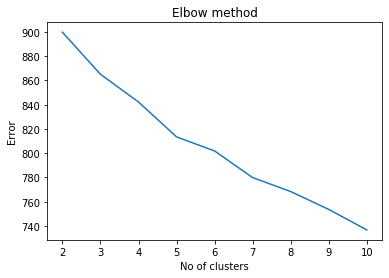

In [94]:

plt.plot(range(2, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

In [137]:
kmeans = KMeans(n_clusters = 2).fit(csr_mat_svd)
kmeans.fit(csr_mat_svd)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [138]:
kmeans_label = kmeans.predict(csr_mat_svd)

In [139]:
pd.value_counts(kmeans_label)

1    5377
0     195
dtype: int64

In [142]:
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
for i in range(2):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 aah
 aa
 aaniy
 aaooooright
 abbey
 aathiwher
 academ
 abdomen
 accident
 access
 abouta
 abt
 absenc
 abroad
 abeg
 absolut
 aburo
 accommodationvouch
 abil
 acid
Cluster 1:
 aa
 ab
 abil
 accident
 abus
 abel
 aaooooright
 aberdeen
 abnorm
 accommodationvouch
 accomod
 accid
 accentur
 account
 abroad
 accordingli
 accumul
 accommod
 abta
 absolut


### Latent Dirichlet Allocation (LDA) 

https://medium.com/analytics-vidhya/topic-modelling-using-latent-dirichlet-allocation-in-scikit-learn-7daf770406c4    
    


In [113]:
# train a LDA Model
lda_model = LatentDirichletAllocation(n_components=5, max_iter=20)

X_topics = lda_model.fit_transform(csr_mat)


In [114]:
for index, topic in enumerate(lda_model.components_):
    print(f'Top 5 words for Topic #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-5:]])
    print('\n')


Top 5 words for Topic #0
['collect', 'go', 'ur', 'call', 'im']


Top 5 words for Topic #1
['claim', 'repli', 'mobil', 'free', 'call']


Top 5 words for Topic #2
['come', 'wat', 'go', 'lor', 'ok']


Top 5 words for Topic #3
['get', 'later', 'sorri', 'call', 'ill']


Top 5 words for Topic #4
['love', 'im', 'get', 'go', 'home']




#### Tuning Paramters for LDA

In [129]:
lda_params = {
                'n_components' : [2,3,4,5,6,7],
                'learning_decay': [.4,.6,.8,1.0],
                'max_iter' : [5,10,20,30]
             }

In [130]:
lda = LatentDirichletAllocation()

In [131]:
model_lda = GridSearchCV(lda, param_grid=lda_params)

In [132]:
model_lda.fit(csr_mat)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [133]:
model_lda.best_params_

{'learning_decay': 0.4, 'max_iter': 20, 'n_components': 2}

In [134]:
# train a LDA Model
lda_model_tune = LatentDirichletAllocation(n_components=2,learning_decay=0.4, max_iter=20)

In [135]:
X_topics_tune = lda_model_tune.fit_transform(csr_mat)

In [136]:
for index, topic in enumerate(lda_model_tune.components_):
    print(f'Top 20 words for Topic #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-30:]])
    print('\n')


Top 20 words for Topic #0
['know', 'today', 'miss', 'prize', 'week', 'claim', 'get', 'min', 'ye', 'great', 'day', 'number', 'pl', 'mobil', 'txt', 'repli', 'hi', 'good', 'stop', 'messag', 'new', 'dear', 'phone', 'love', 'pleas', 'ur', 'send', 'text', 'free', 'call']


Top 20 words for Topic #1
['tell', 'take', 'think', 'say', 'ask', 'work', 'da', 'oh', 'wat', 'one', 'know', 'meet', 'need', 'want', 'ltgt', 'still', 'dont', 'lor', 'got', 'later', 'home', 'sorri', 'like', 'time', 'get', 'ill', 'come', 'go', 'im', 'ok']




Topic 1 is most likely to be "spam" topic. Topic 2 is most likely "ham" topic.
